In [1]:
import torch
print(torch.cuda.is_available())

True


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
from PIL import Image
import torch
import numpy as np
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split

In [4]:
class FaceDataset(Dataset):
    def __init__(self, img_dir, label_dir, img_size=448, grid_size=14, num_bboxes=1, max_images=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_size = img_size
        self.grid_size = grid_size
        self.num_bboxes = num_bboxes
        self.transform = transform
        self.img_files = []
        count = 0
        for img_file in os.listdir(img_dir):
            if img_file.endswith('.jpg'):
                self.img_files.append(img_file)
                count += 1
                if max_images is not None and count >= max_images:
                    break

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        img = Image.open(img_path).convert("RGB")
        img = img.resize((self.img_size, self.img_size))

        if self.transform:
            img = self.transform(img)

        label_path = os.path.join(self.label_dir, self.img_files[idx].replace('.jpg', '.txt'))
        boxes = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                for line in file:
                    _, x_center, y_center, width, height = map(float, line.strip().split())
                    boxes.append([x_center, y_center, width, height, 1.0])

        target_grid = self.map_targets_to_grid(boxes, self.grid_size, self.num_bboxes)

        return img, target_grid

    def map_targets_to_grid(self, targets, grid_size, num_bboxes):
        target_grid = torch.zeros((grid_size, grid_size, num_bboxes * 5))

        for target in targets:
            x_center, y_center, width, height, conf = target
            #print('-------------------------------------')
            #print(x_center, y_center, width, height, conf)
            grid_x = int(x_center * grid_size)
            grid_y = int(y_center * grid_size)

            x_center = (x_center * grid_size) - grid_x
            y_center = (y_center * grid_size) - grid_y
            #print(x_center, y_center, width, height, conf)
            bbox_index = 0
            target_grid[grid_y, grid_x, bbox_index * 5:bbox_index * 5 + 4] = torch.tensor([x_center, y_center, width, height])
            target_grid[grid_y, grid_x, bbox_index * 5 + 4] = conf

        return target_grid


In [5]:
img_dir_train='/content/drive/My Drive/YoloData/images/train'
label_dir_train='/content/drive/My Drive/YoloData/labels/train'
img_dir_test='/content/drive/My Drive/YoloData/images/val'
label_dir_test='/content/drive/My Drive/YoloData/labels/val'

data_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_val_dataset = FaceDataset(
    img_dir=img_dir_train,
    label_dir=label_dir_train,
    transform=data_transforms,
    max_images=5000
)
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

test_dataset = FaceDataset(
    img_dir=img_dir_test,
    label_dir=label_dir_test,
    transform=data_transforms,
    max_images=1000
)

In [6]:
def collate_fn(batch):
    images, targets = zip(*batch)

    images = torch.stack(images, dim=0)

    return images, targets

In [7]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2,collate_fn=collate_fn)
val_loader = DataLoader(val_dataset,batch_size=16,shuffle=True,num_workers=2,collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2,collate_fn=collate_fn)

In [8]:
#train_dataset[0]

In [9]:
import torch
import torch.nn as nn
import numpy as np

In [10]:
class YOLO(nn.Module):
  def __init__(self,grid_size=14,num_bboxes=1):
    super(YOLO,self).__init__()
    self.grid_size=grid_size
    self.num_bboxes=num_bboxes
    self.num_classes=1

    self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 128, kernel_size=1, stride=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),

            nn.Conv2d(256, 256, kernel_size=1, stride=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2) #14x14x512
        )

    self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * self.grid_size * self.grid_size, 4096),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, self.grid_size * self.grid_size * (self.num_bboxes * 5))
        )

  def forward(self, x):

        x = self.conv_layers(x)
        x = self.fc_layers(x)

        x = x.view(-1, self.grid_size, self.grid_size, self.num_bboxes * 5)

        bboxes = torch.sigmoid(x[..., :self.num_bboxes * 5])

        return bboxes
  def predict(self, x, iou_threshold=0.5, confidence_threshold=0.5):
        bboxes = self.forward(x)

        filtered_boxes = []
        filtered_scores = []


        for i in range(self.grid_size):
            for j in range(self.grid_size):
                for b in range(self.num_bboxes):
                    offset = b * 5
                    confidence = bboxes[:, i, j, offset + 4]
                    if confidence > confidence_threshold:
                        box = bboxes[:, i, j, offset:offset + 4]
                        score = confidence
                        filtered_boxes.append(box)
                        filtered_scores.append(score)


        if len(filtered_boxes) == 0:
            return [], []

        filtered_boxes = torch.stack(filtered_boxes)
        filtered_scores = torch.stack(filtered_scores)


        keep_indices = nms(filtered_boxes, filtered_scores, iou_threshold)
        final_boxes = filtered_boxes[keep_indices]
        final_scores = filtered_scores[keep_indices]


        return final_boxes, final_scores


In [11]:
def xywh_to_xyxy(box):
    x_center, y_center, width, height = box[..., 0], box[..., 1], box[..., 2], box[..., 3]
    x_min = x_center - width / 2
    y_min = y_center - height / 2
    x_max = x_center + width / 2
    y_max = y_center + height / 2
    return torch.stack([x_min, y_min, x_max, y_max], dim=-1)

In [12]:
def iou(boxes1, boxes2):
    boxes1 = xywh_to_xyxy(boxes1)
    boxes2 = xywh_to_xyxy(boxes2)

    inter_x_min = torch.max(boxes1[..., 0], boxes2[..., 0])
    inter_y_min = torch.max(boxes1[..., 1], boxes2[..., 1])
    inter_x_max = torch.min(boxes1[..., 2], boxes2[..., 2])
    inter_y_max = torch.min(boxes1[..., 3], boxes2[..., 3])

    inter_area = torch.clamp(inter_x_max - inter_x_min, min=0) * torch.clamp(inter_y_max - inter_y_min, min=0)

    area1 = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    area2 = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    union_area = area1 + area2 - inter_area
    iou = inter_area / torch.clamp(union_area, min=1e-6)

    return iou

In [13]:
def nms(bboxes, scores, iou_threshold=0.5):
    keep = []
    indices = scores.sort(descending=True)[1]

    while indices.numel() > 0:
        current = indices[0]
        keep.append(current.item())
        if indices.numel() == 1:
            break

        ious = iou(bboxes[current], bboxes[indices[1:]])
        indices = indices[1:][ious < iou_threshold]

    return keep

In [14]:
import torch

def yolo_loss(pred_bboxes, target, lambda_coord=5,lambda_size=5,lambda_obj=1, lambda_noobj=0.5):
    obj_mask = target[..., 4] > 0
    noobj_mask = target[..., 4] == 0

    coord_center_loss = lambda_coord * torch.sum((pred_bboxes[obj_mask][..., :2] - target[obj_mask][..., :2]) ** 2)
    coord_size_loss = lambda_size * torch.sum((pred_bboxes[obj_mask][..., 2:4] - target[obj_mask][..., 2:4]) ** 2)

    iou_scores = iou(pred_bboxes[obj_mask][..., :4], target[obj_mask][..., :4])

    obj_loss = lambda_obj*torch.sum((iou_scores-pred_bboxes[obj_mask][..., 4]) ** 2)
    noobj_loss = lambda_noobj * torch.sum(target[noobj_mask][..., 4]** 2)
    #noobj_loss_1 = lambda_noobj * torch.sum(torch.clamp(pred_bboxes[noobj_mask_1][..., 4], min=1e-6) ** 2)

    loss = coord_center_loss + coord_size_loss + obj_loss + noobj_loss
    return loss


In [15]:
model = YOLO()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

YOLO(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_s

In [16]:
from tqdm import tqdm
import torch.optim as optim

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.0001,checkpoint_dir='/content/drive/My Drive/checkpoints',patience=5):
    training_losses = []
    validation_losses = []
    best_val_loss = np.inf
    epochs_no_improve = 0

    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=0.0005)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch + 1}/{num_epochs}]")

        for images, targets in progress_bar:
            images = images.to(device)

            targets = [target.to(device) for target in targets]

            optimizer.zero_grad()

            bboxes = model(images) #(8,14,14,5)

            losses = [yolo_loss(bbox, target) for bbox, target in zip(bboxes, targets)]
            loss = torch.mean(torch.stack(losses))

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({'Loss': loss.item()})

        avg_loss = running_loss / len(train_loader)
        training_losses.append(avg_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss}")

        scheduler.step()

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for val_images, val_targets in val_loader:
                val_images = val_images.to(device)
                val_targets = [val_target.to(device) for val_target in val_targets]

                val_bboxes = model(val_images)
                val_losses = [yolo_loss(val_bbox, val_target) for val_bbox, val_target in zip(val_bboxes, val_targets)]
                val_loss = torch.mean(torch.stack(val_losses))

                val_running_loss += val_loss.item()

        avg_val_loss = val_running_loss / len(val_loader)
        validation_losses.append(avg_val_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss}")
        if((epoch+1)%2==0):
          save_checkpoint(model, optimizer, epoch + 1, avg_loss, checkpoint_dir)
        model.train()

    print("Training complete!")
    return training_losses,validation_losses


In [17]:
def save_checkpoint(model, optimizer, epoch, loss, checkpoint_dir="checkpoints"):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    checkpoint_path = os.path.join(checkpoint_dir, f"V3_model_epoch_{epoch}_loss_{loss:.4f}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

In [18]:
def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Loaded checkpoint '{checkpoint_path}' (epoch {epoch}, loss {loss})")
    return epoch, loss

In [73]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def predict_and_draw(model, test_loader, device):
    model.eval()

    data_iter = iter(test_loader)
    next(data_iter)
    next(data_iter)
    next(data_iter)
    #next(data_iter)
    #next(data_iter)
    images, targets = next(data_iter)
    image = images[0].unsqueeze(0).to(device)
    print("Image size:", image.shape)

    with torch.no_grad():
        predictions = model(image)

    predictions = predictions[0].cpu().numpy()

    img = images[0].permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    ax = plt.gca()

    grid_size = 14
    num_bboxes = 1

    for i in range(grid_size):
        for j in range(grid_size):
            confidence = predictions[i, j, 4]
            if confidence > 0.3:
                x_center, y_center, width, height = predictions[i, j, :4]
                print(f"Box: {i},{j}")
                print(x_center, y_center, width, height, confidence)


                x_center = (x_center + j) / grid_size
                y_center = (y_center + i) / grid_size

                xmin = x_center - width / 2
                ymin = y_center - height / 2
                xmax = x_center + width / 2
                ymax = y_center + height / 2


                xmin *= img.shape[1]
                xmax *= img.shape[1]
                ymin *= img.shape[0]
                ymax *= img.shape[0]

                rect = plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, color='red')
                ax.add_patch(rect)

    plt.axis('off')
    plt.show()


In [20]:
training_losses,validation_losses = train_model(model,train_loader,val_loader,num_epochs=10)

Epoch [1/10]: 100%|██████████| 250/250 [25:24<00:00,  6.10s/it, Loss=3.32]

Epoch [1/10], Loss: 9.154522296905517


Epoch [1/10], Validation Loss: 6.052234085779341


Epoch [2/10]: 100%|██████████| 250/250 [02:44<00:00,  1.52it/s, Loss=3.25]

Epoch [2/10], Loss: 6.052073957443238


Epoch [2/10], Validation Loss: 4.49444365879846
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_2_loss_6.0521.pth


Epoch [3/10]: 100%|██████████| 250/250 [03:11<00:00,  1.30it/s, Loss=4.65]

Epoch [3/10], Loss: 5.331915165901184


Epoch [3/10], Validation Loss: 4.45310780358693


Epoch [4/10]: 100%|██████████| 250/250 [02:42<00:00,  1.54it/s, Loss=3.05]

Epoch [4/10], Loss: 4.949931874275207


Epoch [4/10], Validation Loss: 4.594199176818606
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_4_loss_4.9499.pth


Epoch [5/10]: 100%|██████████| 250/250 [03:09<00:00,  1.32it/s, Loss=5.63]

Epoch [5/10], Loss: 4.720980969429016


Epoch [5/10], Validation Loss: 5.366607079430232


Epoch [6/10]: 100%|██████████| 250/250 [02:42<00:00,  1.53it/s, Loss=5.45]

Epoch [6/10], Loss: 4.607016804695129


Epoch [6/10], Validation Loss: 4.406954511763558
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_6_loss_4.6070.pth


Epoch [7/10]: 100%|██████████| 250/250 [03:09<00:00,  1.32it/s, Loss=4.26]

Epoch [7/10], Loss: 4.4704037952423095


Epoch [7/10], Validation Loss: 4.346398031900799


Epoch [8/10]: 100%|██████████| 250/250 [02:42<00:00,  1.54it/s, Loss=5.39]

Epoch [8/10], Loss: 4.178368663787841


Epoch [8/10], Validation Loss: 4.717880536639501
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_8_loss_4.1784.pth


Epoch [9/10]: 100%|██████████| 250/250 [03:03<00:00,  1.36it/s, Loss=7.17]

Epoch [9/10], Loss: 3.8166894111633303


Epoch [9/10], Validation Loss: 4.924910719432528


Epoch [10/10]: 100%|██████████| 250/250 [02:47<00:00,  1.49it/s, Loss=8.34]

Epoch [10/10], Loss: 3.58315243434906


Epoch [10/10], Validation Loss: 4.31258389684889
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_10_loss_3.5832.pth
Training complete!


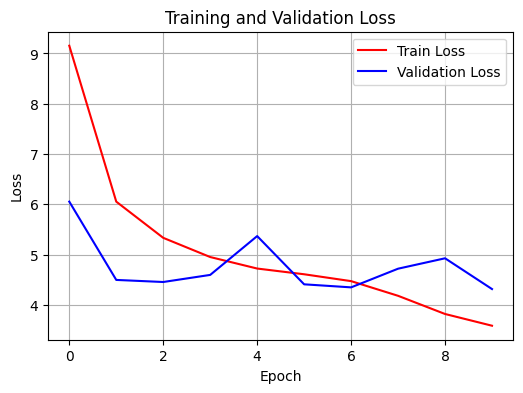

In [25]:
plt.figure(figsize=(6,4 ))
plt.plot(training_losses, label='Train Loss', color='red')
plt.plot(validation_losses, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.0001,weight_decay=0.0005)
load_checkpoint('/content/drive/My Drive/checkpoints/V3_model_epoch_10_loss_3.5832.pth',model,optimizer)

<ipython-input-18-d2648ef6c5b6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint '/content/drive/My Drive/checkpoints/V2_model_epoch_8_loss_8.4151.pth' (epoch 8, loss 8.415054872512817)


(8, 8.415054872512817)

Image size: torch.Size([1, 3, 448, 448])
Box: 0,0
0.6368248 0.7154832 0.015073513 0.03266989 0.014933689
Box: 0,1
0.7342232 0.8131757 0.018772762 0.01793079 0.020673523
Box: 0,2
0.5381364 0.8684208 0.029882422 0.047351178 0.014616843
Box: 0,3
0.5802021 0.42367786 0.014096963 0.051314984 0.022423226
Box: 0,4
0.5050313 0.40532625 0.063603744 0.016610282 0.00702538
Box: 0,5
0.649762 0.8834096 0.016951585 0.012752348 0.019386066
Box: 0,6
0.24350642 0.6210533 0.025314081 0.04980302 0.0077427886
Box: 0,7
0.5811535 0.5989177 0.006926259 0.015621827 0.007864289
Box: 0,8
0.39194435 0.6450569 0.031739037 0.0541762 0.041613724
Box: 0,9
0.48949564 0.546528 0.047582448 0.029146675 0.013674362
Box: 0,10
0.6331332 0.3515231 0.014534663 0.033070512 0.0129690245
Box: 0,11
0.28934723 0.47451967 0.0024846878 0.0093310755 0.018707804
Box: 0,12
0.8281397 0.8503776 0.0044782883 0.015162638 0.012442169
Box: 0,13
0.42173433 0.79713994 0.017232873 0.012438537 0.0034596173
Box: 1,0
0.4661358 0.656676 0.00996645

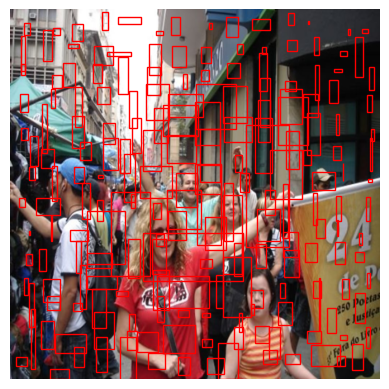

In [26]:
predict_and_draw(model,train_loader,device)

In [27]:
training_losses_next10,validation_losses_next10 = train_model(model,train_loader,val_loader,num_epochs=10)

Epoch [1/10]: 100%|██████████| 250/250 [02:43<00:00,  1.53it/s, Loss=2.49]

Epoch [1/10], Loss: 3.3179716923236846


Epoch [1/10], Validation Loss: 4.455061704393417


Epoch [2/10]: 100%|██████████| 250/250 [02:43<00:00,  1.53it/s, Loss=4.94]

Epoch [2/10], Loss: 3.3097275347709654


Epoch [2/10], Validation Loss: 4.480187684770614
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_2_loss_3.3097.pth


Epoch [3/10]: 100%|██████████| 250/250 [03:10<00:00,  1.31it/s, Loss=4.07]

Epoch [3/10], Loss: 3.0574706139564514


Epoch [3/10], Validation Loss: 4.578875040251111


Epoch [4/10]: 100%|██████████| 250/250 [02:42<00:00,  1.54it/s, Loss=5.09]

Epoch [4/10], Loss: 2.94516041636467


Epoch [4/10], Validation Loss: 4.818467208317348
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_4_loss_2.9452.pth


Epoch [5/10]: 100%|██████████| 250/250 [03:15<00:00,  1.28it/s, Loss=3.4]

Epoch [5/10], Loss: 2.782645142555237


Epoch [5/10], Validation Loss: 4.682747691396683


Epoch [6/10]: 100%|██████████| 250/250 [02:42<00:00,  1.54it/s, Loss=2.03]

Epoch [6/10], Loss: 2.6284433023929594


Epoch [6/10], Validation Loss: 4.722355501992362
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_6_loss_2.6284.pth


Epoch [7/10]: 100%|██████████| 250/250 [03:10<00:00,  1.31it/s, Loss=1.15]

Epoch [7/10], Loss: 2.4463633370399473


Epoch [7/10], Validation Loss: 4.910098601901342


Epoch [8/10]: 100%|██████████| 250/250 [02:43<00:00,  1.53it/s, Loss=2.75]

Epoch [8/10], Loss: 2.4680402071475984


Epoch [8/10], Validation Loss: 5.522863622695681
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_8_loss_2.4680.pth


Epoch [9/10]: 100%|██████████| 250/250 [03:09<00:00,  1.32it/s, Loss=3.56]

Epoch [9/10], Loss: 2.232886267900467


Epoch [9/10], Validation Loss: 4.595146069450984


Epoch [10/10]: 100%|██████████| 250/250 [02:45<00:00,  1.51it/s, Loss=1.54]

Epoch [10/10], Loss: 2.303822957754135


Epoch [10/10], Validation Loss: 4.902565573889111
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_10_loss_2.3038.pth
Training complete!


In [29]:
training_losses.extend(training_losses_next10)
validation_losses.extend(validation_losses_next10)

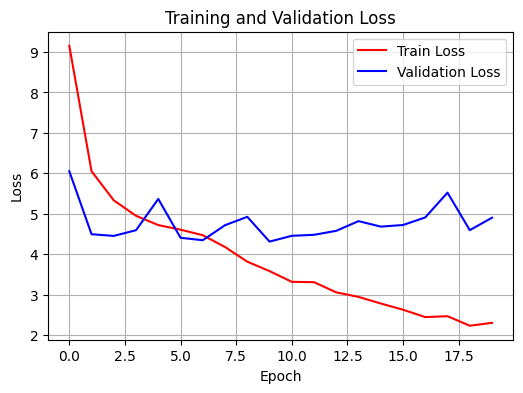

In [30]:
plt.figure(figsize=(6,4 ))
plt.plot(training_losses, label='Train Loss', color='red')
plt.plot(validation_losses, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Image size: torch.Size([1, 3, 448, 448])
Box: 0,1
0.46758172 0.63651633 0.03088202 0.16748129 0.1871415
Box: 0,3
0.70569503 0.48046052 0.12878804 0.14115593 0.10624094
Box: 0,4
0.60272664 0.46493003 0.10114812 0.08456971 0.13551189
Box: 0,6
0.8723159 0.81114936 0.09167342 0.243761 0.101672485
Box: 0,8
0.51709986 0.3679347 0.20357 0.20790403 0.13696109
Box: 0,12
0.5686997 0.8370449 0.2346876 0.1528715 0.11705057
Box: 1,2
0.3497013 0.271874 0.1393002 0.23015332 0.15451564
Box: 1,7
0.48697641 0.64589757 0.10342916 0.13190122 0.1018566
Box: 1,11
0.55870163 0.2839394 0.16745286 0.29569936 0.14685692
Box: 2,1
0.18450879 0.2936291 0.13065287 0.2581318 0.12116125
Box: 4,6
0.8833169 0.77416176 0.34457377 0.2649976 0.19671434
Box: 4,8
0.8015206 0.7556722 0.101560906 0.21222387 0.1287091
Box: 5,6
0.2626787 0.2586534 0.1431588 0.20423846 0.10737176
Box: 6,2
0.500952 0.6714406 0.16266327 0.2197938 0.14286701
Box: 6,4
0.4368381 0.517127 0.12124971 0.11329747 0.11329957
Box: 6,5
0.26387987 0.61533934

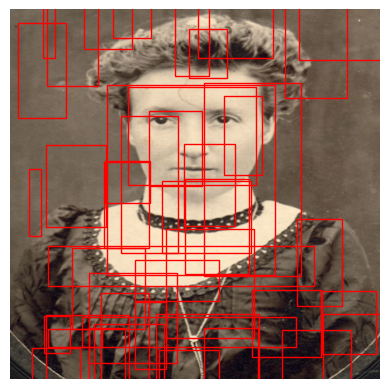

In [68]:
predict_and_draw(model,train_loader,device)

In [69]:
training_losses_next10,validation_losses_next10 = train_model(model,train_loader,val_loader,num_epochs=10)

Epoch [1/10]: 100%|██████████| 250/250 [02:46<00:00,  1.50it/s, Loss=2.11]

Epoch [1/10], Loss: 2.285426638364792


Epoch [1/10], Validation Loss: 4.9953143028985885


Epoch [2/10]: 100%|██████████| 250/250 [02:42<00:00,  1.54it/s, Loss=1.97]

Epoch [2/10], Loss: 2.216895165681839


Epoch [2/10], Validation Loss: 4.565181134239076
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_2_loss_2.2169.pth


Epoch [3/10]: 100%|██████████| 250/250 [03:21<00:00,  1.24it/s, Loss=4.72]

Epoch [3/10], Loss: 2.0293488326072695


Epoch [3/10], Validation Loss: 4.607451567574153


Epoch [4/10]: 100%|██████████| 250/250 [02:43<00:00,  1.53it/s, Loss=1.04]

Epoch [4/10], Loss: 1.5746513801813125


Epoch [4/10], Validation Loss: 4.050101802462623
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_4_loss_1.5747.pth


Epoch [5/10]: 100%|██████████| 250/250 [03:13<00:00,  1.29it/s, Loss=0.668]

Epoch [5/10], Loss: 1.0601071413755416


Epoch [5/10], Validation Loss: 4.153266677780757


Epoch [6/10]: 100%|██████████| 250/250 [02:49<00:00,  1.48it/s, Loss=1.31]

Epoch [6/10], Loss: 0.8341397025585174


Epoch [6/10], Validation Loss: 4.201200095434038
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_6_loss_0.8341.pth


Epoch [7/10]: 100%|██████████| 250/250 [03:33<00:00,  1.17it/s, Loss=0.488]

Epoch [7/10], Loss: 0.7160083330869674


Epoch [7/10], Validation Loss: 3.826367226857988


Epoch [8/10]: 100%|██████████| 250/250 [02:47<00:00,  1.49it/s, Loss=0.644]

Epoch [8/10], Loss: 0.6260865139961242


Epoch [8/10], Validation Loss: 3.900603415474059
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_8_loss_0.6261.pth


Epoch [9/10]: 100%|██████████| 250/250 [03:16<00:00,  1.27it/s, Loss=0.492]

Epoch [9/10], Loss: 0.5804058126211167


Epoch [9/10], Validation Loss: 3.766217349067567


Epoch [10/10]: 100%|██████████| 250/250 [02:45<00:00,  1.51it/s, Loss=0.733]

Epoch [10/10], Loss: 0.5626831287145615


Epoch [10/10], Validation Loss: 3.703469997360593
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_10_loss_0.5627.pth
Training complete!


In [70]:
training_losses.extend(training_losses_next10)
validation_losses.extend(validation_losses_next10)

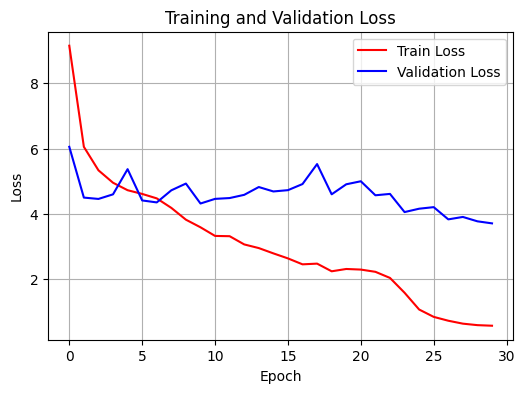

In [71]:
plt.figure(figsize=(6,4 ))
plt.plot(training_losses, label='Train Loss', color='red')
plt.plot(validation_losses, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Image size: torch.Size([1, 3, 448, 448])
Box: 7,9
0.08525114 0.5962468 0.23228951 0.53983766 0.38627645
Box: 13,7
0.46215832 0.4210662 0.40126765 0.4053761 0.4339582


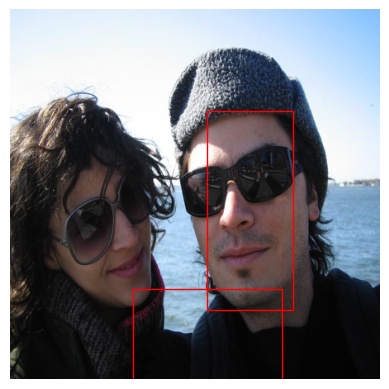

In [83]:
predict_and_draw(model,train_loader,device)

In [84]:
training_losses_next10,validation_losses_next10 = train_model(model,train_loader,val_loader,num_epochs=10)

Epoch [1/10]: 100%|██████████| 250/250 [02:45<00:00,  1.51it/s, Loss=0.92]

Epoch [1/10], Loss: 0.6308956463336944


Epoch [1/10], Validation Loss: 3.7824437693944053


Epoch [2/10]: 100%|██████████| 250/250 [02:42<00:00,  1.53it/s, Loss=0.915]

Epoch [2/10], Loss: 0.6713516973257064


Epoch [2/10], Validation Loss: 3.74948237245045
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_2_loss_0.6714.pth


Epoch [3/10]: 100%|██████████| 250/250 [03:11<00:00,  1.31it/s, Loss=0.364]

Epoch [3/10], Loss: 0.6328453186154366


Epoch [3/10], Validation Loss: 3.851506645717318


Epoch [4/10]: 100%|██████████| 250/250 [02:42<00:00,  1.54it/s, Loss=0.684]

Epoch [4/10], Loss: 0.5753407445549965


Epoch [4/10], Validation Loss: 3.8156495491663613
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_4_loss_0.5753.pth


Epoch [5/10]: 100%|██████████| 250/250 [03:08<00:00,  1.33it/s, Loss=0.375]

Epoch [5/10], Loss: 0.545902829527855


Epoch [5/10], Validation Loss: 3.696221726281302


Epoch [6/10]: 100%|██████████| 250/250 [02:41<00:00,  1.55it/s, Loss=0.678]

Epoch [6/10], Loss: 0.5323431159853935


Epoch [6/10], Validation Loss: 3.941947781850421
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_6_loss_0.5323.pth


Epoch [7/10]: 100%|██████████| 250/250 [03:07<00:00,  1.33it/s, Loss=0.583]

Epoch [7/10], Loss: 0.5197892082333565


Epoch [7/10], Validation Loss: 3.6235034163036044


Epoch [8/10]: 100%|██████████| 250/250 [02:43<00:00,  1.53it/s, Loss=0.469]

Epoch [8/10], Loss: 0.5055078575015068


Epoch [8/10], Validation Loss: 3.9431752742282926
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_8_loss_0.5055.pth


Epoch [9/10]: 100%|██████████| 250/250 [03:08<00:00,  1.33it/s, Loss=0.422]

Epoch [9/10], Loss: 0.5219032571911811


Epoch [9/10], Validation Loss: 3.6973199049631753


Epoch [10/10]: 100%|██████████| 250/250 [02:43<00:00,  1.53it/s, Loss=0.483]

Epoch [10/10], Loss: 0.5252268314957619


Epoch [10/10], Validation Loss: 3.792384018973699
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_10_loss_0.5252.pth
Training complete!


In [85]:
training_losses.extend(training_losses_next10)
validation_losses.extend(validation_losses_next10)

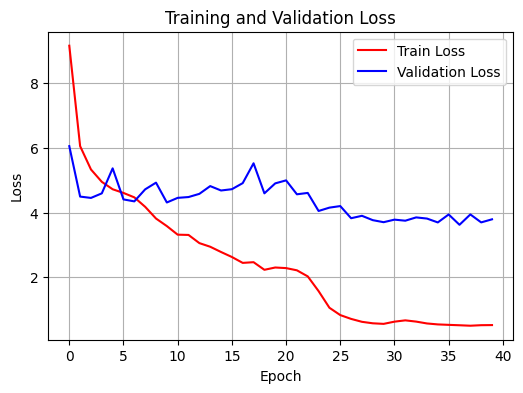

In [86]:
plt.figure(figsize=(6,4 ))
plt.plot(training_losses, label='Train Loss', color='red')
plt.plot(validation_losses, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [87]:
training_losses_next10,validation_losses_next10 = train_model(model,train_loader,val_loader,num_epochs=10)

Epoch [1/10]: 100%|██████████| 250/250 [03:33<00:00,  1.17it/s, Loss=0.364]

Epoch [1/10], Loss: 0.522080237686634


Epoch [1/10], Validation Loss: 3.6632114743429516


Epoch [2/10]: 100%|██████████| 250/250 [02:41<00:00,  1.55it/s, Loss=0.491]

Epoch [2/10], Loss: 0.5138546227812767


Epoch [2/10], Validation Loss: 3.6482196686759827
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_2_loss_0.5139.pth


Epoch [3/10]: 100%|██████████| 250/250 [03:14<00:00,  1.28it/s, Loss=0.361]

Epoch [3/10], Loss: 0.480948533654213


Epoch [3/10], Validation Loss: 3.662329537527902


Epoch [4/10]: 100%|██████████| 250/250 [02:45<00:00,  1.51it/s, Loss=0.329]

Epoch [4/10], Loss: 0.46518102353811264


Epoch [4/10], Validation Loss: 3.5578178489019
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_4_loss_0.4652.pth


Epoch [5/10]: 100%|██████████| 250/250 [03:12<00:00,  1.30it/s, Loss=0.32]

Epoch [5/10], Loss: 0.4671042284369469


Epoch [5/10], Validation Loss: 3.5133700787074984


Epoch [6/10]: 100%|██████████| 250/250 [02:45<00:00,  1.51it/s, Loss=0.334]

Epoch [6/10], Loss: 0.45100552052259446


Epoch [6/10], Validation Loss: 3.517518709576319
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_6_loss_0.4510.pth


Epoch [7/10]: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s, Loss=0.518]

Epoch [7/10], Loss: 0.4451322250366211


Epoch [7/10], Validation Loss: 3.5472379090294006


Epoch [8/10]: 100%|██████████| 250/250 [02:47<00:00,  1.50it/s, Loss=0.445]

Epoch [8/10], Loss: 0.4509216905236244


Epoch [8/10], Validation Loss: 3.492807762963431
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_8_loss_0.4509.pth


Epoch [9/10]: 100%|██████████| 250/250 [03:14<00:00,  1.29it/s, Loss=0.707]

Epoch [9/10], Loss: 0.4367735871076584


Epoch [9/10], Validation Loss: 3.493763180006118


Epoch [10/10]: 100%|██████████| 250/250 [02:48<00:00,  1.49it/s, Loss=0.35]

Epoch [10/10], Loss: 0.43490461975336075


Epoch [10/10], Validation Loss: 3.450538060021779
Checkpoint saved at /content/drive/My Drive/checkpoints/V3_model_epoch_10_loss_0.4349.pth
Training complete!


In [88]:
training_losses.extend(training_losses_next10)
validation_losses.extend(validation_losses_next10)

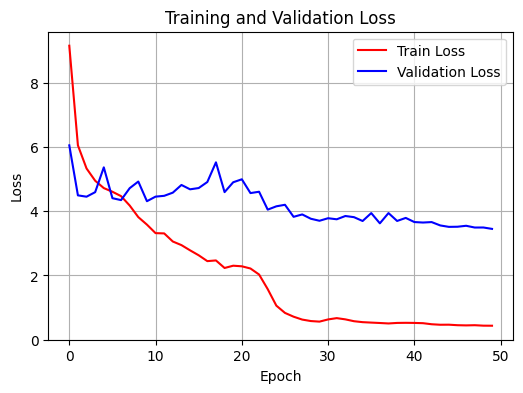

In [89]:
plt.figure(figsize=(6,4 ))
plt.plot(training_losses, label='Train Loss', color='red')
plt.plot(validation_losses, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Image size: torch.Size([1, 3, 448, 448])
Box: 1,2
0.34265003 0.43920454 0.28418767 0.3055005 0.3747208
Box: 1,11
0.71543145 0.50578284 0.3268632 0.402254 0.3238654
Box: 2,6
0.71725625 0.73324305 0.48296154 0.31462437 0.323331
Box: 3,6
0.7328256 0.570508 0.40551335 0.3306267 0.4811866
Box: 3,8
0.35208327 0.6412399 0.24424715 0.3210747 0.3039715
Box: 4,3
0.6808067 0.5355793 0.21780147 0.30541193 0.40793902
Box: 4,5
0.68746096 0.50033915 0.16468975 0.25481182 0.4746463
Box: 4,7
0.6937559 0.30792126 0.21886286 0.30472046 0.30194667
Box: 4,8
0.49714595 0.6052791 0.33984825 0.35674697 0.34293407
Box: 5,4
0.35317788 0.4255043 0.1876483 0.32378396 0.33298472
Box: 5,5
0.58637047 0.7053166 0.3683752 0.4672252 0.40329963
Box: 5,6
0.5153268 0.72509885 0.4294348 0.51240134 0.60575676
Box: 5,7
0.5153859 0.6836098 0.4796741 0.60354066 0.5843343
Box: 5,8
0.5122454 0.4849101 0.36651552 0.35500243 0.42970046
Box: 5,11
0.3768904 0.22842295 0.14916275 0.28775203 0.3451423
Box: 6,4
0.27085578 0.62916327 0.

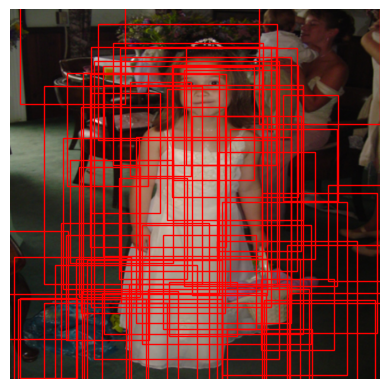

In [94]:
predict_and_draw(model,train_loader,device)

In [24]:
load_checkpoint('/content/drive/My Drive/checkpoints/V2_model_epoch_16_loss_1.5141.pth',model,optimizer)

<ipython-input-18-d2648ef6c5b6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint '/content/drive/My Drive/checkpoints/V2_model_epoch_16_loss_1.5141.pth' (epoch 16, loss 1.514097965568304)


(16, 1.514097965568304)

Image size: torch.Size([1, 3, 448, 448])
Box: 0,0
0.36928996 0.5949714 0.0027905751 0.0018141883 0.020663572
Box: 0,1
0.5833995 0.701642 0.0047758003 0.0079075685 0.018386744
Box: 0,2
0.37923628 0.35633928 0.0018519263 0.0042423927 0.022177221
Box: 0,3
0.8067977 0.3857283 0.0006075711 0.0008239163 0.015016863
Box: 0,4
0.3611927 0.40237263 0.0013959536 0.00097648473 0.02007074
Box: 0,5
0.4315426 0.54692864 0.0026791045 0.0028002588 0.012052263
Box: 0,6
0.8608827 0.6203187 0.00049375725 0.00016255093 0.008429896
Box: 0,7
0.4355499 0.5843411 0.0016462206 0.005137922 0.027292727
Box: 0,8
0.40270242 0.66003436 0.0018885073 0.005035863 0.020439187
Box: 0,9
0.5757826 0.6925781 0.0011090662 0.0005932884 0.017181208
Box: 0,10
0.33256656 0.7017587 0.0005688036 0.00019611833 0.015476356
Box: 0,11
0.4253361 0.56187207 0.00046126454 0.00023574801 0.009531452
Box: 0,12
0.65120935 0.6304754 0.0005832596 0.00077593134 0.019364214
Box: 0,13
0.6905856 0.715696 0.0010474306 0.0007819404 0.018457418
Box: 

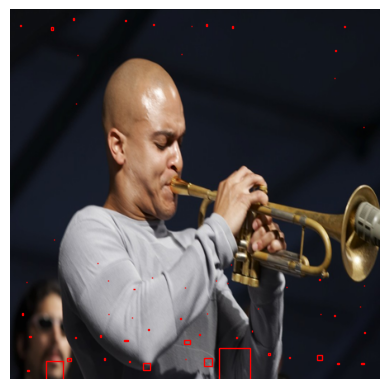

In [37]:
predict_and_draw(model,train_loader,device)